### Module Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error

import scipy.stats as stats #used in Q-Q plot
import statsmodels.api as sm #used in Q-Q plots

### Read in Data

In [2]:
#import data
df = pd.read_csv('./data/modeling_data.csv')

### Useful Functions

In [3]:
# convert object dtypes to numerics
def df_to_numeric(dataframe):
    '''fn takes in a dataframe and changes features to numeric types if possible'''
    for col in dataframe.columns:
        try:
            dataframe[col] = pd.to_numeric(dataframe[col])
        except:
            pass
    return dataframe

In [4]:
#create function to add each model scores to df
def new_score(model, model_name):
    '''fn takes in a linear regression (or ridge/lasso model), and a name for the 
    particular model to score. It returns the df updated with the various metrics 
    for that model. This works when the x/y train/test split are already defined.'''
        
    cv_score = round(cross_val_score(model, X_train, y_train).mean(),3)
    
    r2_train = round(model.score(X_train, y_train),3)
    r2_test = round(model.score(X_test, y_test),3)

    rmse_train = round(mean_squared_error(y_train, model.predict(X_train))**0.5)
    rmse_test = round(mean_squared_error(y_test, model.predict(X_test))**0.5)
    
    scores.loc[model_name] = [cv_score, r2_train, r2_test, rmse_train, rmse_test]
    
    return scores

In [5]:
# define a function to calculate VIF manually
# code is borrowed from the linear assumptions lesson
def calc_vif(data, feats):
    v_df = pd.DataFrame(columns = ['r2', 'tolerance', 'vif'],
                       index = feats)

    for feat in feats: #fit linear models for each independent against all else
        X = data.drop(columns = feat)
        y = data[[feat]]
        
        lr = LinearRegression()
        lr.fit(X, y)
        
        r2 = lr.score(X, y)
        tol = (1 - r2)
        vif = 1/tol
        
        v_df.loc[feat] = [r2, tol, vif]
        
    return v_df.sort_values(by = 'vif', ascending = False)

---
### Train-Test split

In [6]:
# target is the energy_star_score
# we already removed all entries with null values, but double check
y = df.energy_star_score
y.isnull().sum()

0

In [7]:
# features are all columns except for the target and the property_name (since this is a unique identifier)
X = df.drop(columns=['property_name', 'energy_star_score']) #no neighborhood

In [8]:
#verify shape
X.shape, y.shape

((31486, 38), (31486,))

The first step where I had to 'make a decision' was with regards to the train-test split.
* I set a random_state for consistency
* I set shuffle to True since the original data was sort of alphabetically sorted
* I originally tried a few iterations with train_size = 0.8 and 0.9, but preferred the performance at 0.75 (which is default)
    * I didn't want to go lower than that because 23,000 entries isn't actually THAT much, and I didn't want to reduce my training size further
* Setting `stratify=y` is an interesting characteristic.  
    * I originally added it in because I was used to it from other regression and classification models.  However I noticed after many iterations of my models that I was actually getting higher $R^2$ scores for my testing set than for my training set (for example `train_R2 = 0.319` and `test_R2 = 0.371`).  
    * I removed this and saw that my models were then way overfitting (although still with low scores): `train_R2 = 0.358` and `test_R2 = 0.169`.
    * After multiple iterations and also improving my feature engineering with polynomial features, I got this version of my models which had better train and test scores, and with slightly lower test scores (but not such severe overfitting).  This iteration did include `stratify=y`, so I'm leaving it as is here.
    * In the future, though, I would want to experiment with other stratifications for linear regression, like the ones in this [resource](https://scottclowe.com/2016-03-19-stratified-regression-partitions/) that James shared with me.

In [9]:
# train test split, with explanation above
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42, shuffle=True, 
                                                    train_size=0.75)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23614, 38), (7872, 38), (23614,), (7872,))

In [10]:
#X_train.info()

---
### Imputation and Encoding

---
#### Imputation for null values

This step is necessary because you can't use Nulls as inputs in a Linear Regression model.

In [11]:
#identifying numeric features and string-type features
col_num = X._get_numeric_data().columns
col_str = X.select_dtypes(include='object').columns

In [12]:
# column transformer for simple imputing
# note: I used multiple column transformers instead of one big one,
# because it is easier for me to parse through and make sure my logic flow is correct

ctx_si = ColumnTransformer(
    [('si_num', SimpleImputer(strategy='median'), col_num),           # use median for numerics
     ('si_str', SimpleImputer(strategy='most_frequent'), col_str)],   # use mode for strings
    remainder='passthrough',verbose_feature_names_out=False)

In [13]:
# always fit_transform X_train
X_train_filled = pd.DataFrame(ctx_si.fit_transform(X_train), columns = ctx_si.get_feature_names_out())
# X_train_filled.isnull().sum()   # verify that there are no more nulls

In [14]:
# and only transform X_test
X_test_filled = pd.DataFrame(ctx_si.transform(X_test), columns = ctx_si.get_feature_names_out())
# X_test_filled.isnull().sum()    # verify that there are no more nulls

In [15]:
# applying transformers always seems to convert the data types back to objects, 
# so I'm applying my function here
df_to_numeric(X_train_filled)
df_to_numeric(X_test_filled).head(2)

,year_built,number_of_buildings,occupancy,site_eui_(kbtu/ft²),weather_normalized_site_eui_(kbtu/ft²),national_median_site_eui_(kbtu/ft²),site_energy_use_(kbtu),weather_normalized_site_energy_use_(kbtu),weather_normalized_site_electricity_intensity_(kwh/ft²),weather_normalized_site_natural_gas_intensity_(therms/ft²),...,net_emissions_(metric_tons_co2e),indirect_ghg_emissions_intensity_(kgco2e/ft²),national_median_total_ghg_emissions_(metric_tons_co2e),egrid_output_emissions_rate_(kgco2e/mbtu),percent_of_electricity_that_is_green_power,property_gfa_-_self-reported_(ft²),water_use_(all_water_sources)_(kgal),number_of_active_energy_meters_-_total,primary_property_type_-_portfolio_manager-calculated,borough
0,1948.0,1.0,100.0,109.1,116.1,77.7,3783787.2,4027264.2,6.3,0.9,...,216.7,1.6,154.3,73.8,0.0,34695.0,4717.7,14.0,Multifamily Housing,QUEENS
1,1927.0,1.0,100.0,78.2,83.2,89.4,6816326.5,7249100.6,3.7,0.1,...,506.9,1.1,579.0,84.5,0.0,87120.0,8723.8,6.0,Multifamily Housing,BRONX


---
#### One Hot Encoding

Also necessary if I want to be able to use the `property_tpe` and `borough` as features.

In [16]:
# apply one hot encoder to the two object features (property_type and borough)
ctx_ohe = ColumnTransformer(
    transformers = [('one_hot',   #alias_first
                     OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False),   #actual transformer
                     col_str)],   #list_of_cols_to_apply_to 
    remainder = 'passthrough',   #don't drop the others
    verbose_feature_names_out=False)   #don't rename the columns with 'one_hot' prefix

In [17]:
X_train_ohe = pd.DataFrame(ctx_ohe.fit_transform(X_train_filled), 
                           columns = ctx_ohe.get_feature_names_out())
X_train_ohe.head(2)

,primary_property_type_-_portfolio_manager-calculated_Courthouse,primary_property_type_-_portfolio_manager-calculated_Data Center,primary_property_type_-_portfolio_manager-calculated_Distribution Center,primary_property_type_-_portfolio_manager-calculated_Financial Office,primary_property_type_-_portfolio_manager-calculated_Hospital (General Medical & Surgical),primary_property_type_-_portfolio_manager-calculated_Hotel,primary_property_type_-_portfolio_manager-calculated_K-12 School,primary_property_type_-_portfolio_manager-calculated_Medical Office,primary_property_type_-_portfolio_manager-calculated_Mixed Use Property,primary_property_type_-_portfolio_manager-calculated_Multifamily Housing,...,direct_ghg_emissions_intensity_(kgco2e/ft²),indirect_ghg_emissions_(metric_tons_co2e),net_emissions_(metric_tons_co2e),indirect_ghg_emissions_intensity_(kgco2e/ft²),national_median_total_ghg_emissions_(metric_tons_co2e),egrid_output_emissions_rate_(kgco2e/mbtu),percent_of_electricity_that_is_green_power,property_gfa_-_self-reported_(ft²),water_use_(all_water_sources)_(kgal),number_of_active_energy_meters_-_total
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,85.3,85.3,1.9,188.1,73.8,0.0,44000.0,224.8,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.6,97.5,156.3,2.7,191.6,73.8,0.0,36000.0,126.4,2.0


In [18]:
X_test_ohe = pd.DataFrame(ctx_ohe.transform(X_test_filled), 
                           columns = ctx_ohe.get_feature_names_out())
X_test_ohe.head(2)

,primary_property_type_-_portfolio_manager-calculated_Courthouse,primary_property_type_-_portfolio_manager-calculated_Data Center,primary_property_type_-_portfolio_manager-calculated_Distribution Center,primary_property_type_-_portfolio_manager-calculated_Financial Office,primary_property_type_-_portfolio_manager-calculated_Hospital (General Medical & Surgical),primary_property_type_-_portfolio_manager-calculated_Hotel,primary_property_type_-_portfolio_manager-calculated_K-12 School,primary_property_type_-_portfolio_manager-calculated_Medical Office,primary_property_type_-_portfolio_manager-calculated_Mixed Use Property,primary_property_type_-_portfolio_manager-calculated_Multifamily Housing,...,direct_ghg_emissions_intensity_(kgco2e/ft²),indirect_ghg_emissions_(metric_tons_co2e),net_emissions_(metric_tons_co2e),indirect_ghg_emissions_intensity_(kgco2e/ft²),national_median_total_ghg_emissions_(metric_tons_co2e),egrid_output_emissions_rate_(kgco2e/mbtu),percent_of_electricity_that_is_green_power,property_gfa_-_self-reported_(ft²),water_use_(all_water_sources)_(kgal),number_of_active_energy_meters_-_total
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4.6,56.0,216.7,1.6,154.3,73.8,0.0,34695.0,4717.7,14.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4.7,96.1,506.9,1.1,579.0,84.5,0.0,87120.0,8723.8,6.0


---
#### Polynomial Features

This step is not necessary but it greatly improved my model performance.  My training scores went from ~0.3 to >0.4, and my testing scores also improved.  Furthermore, I no longer saw the issue where my testing scores were better than my training scores.
* In the future, I would like to spend some time trying to apply PolynomialFeatures to specific quantitative columns, instead of all of them.

In [19]:
# apply polynomial features to all quantitative features
# chose interaction_only so that my feature space doesn't get too large
# set include_bias to False since all values were 1.0 (and were getting scaled to 0.0 after StandardScaler)
ctx_pf = ColumnTransformer(
    transformers = [('poly', 
                     PolynomialFeatures(interaction_only=True, include_bias=False), 
                     col_num)], 
    remainder='passthrough', verbose_feature_names_out=False)

In [20]:
X_train_pf = pd.DataFrame(ctx_pf.fit_transform(X_train_ohe),
                          columns=ctx_pf.get_feature_names_out())
X_train_pf.head(2)

,year_built,number_of_buildings,occupancy,site_eui_(kbtu/ft²),weather_normalized_site_eui_(kbtu/ft²),national_median_site_eui_(kbtu/ft²),site_energy_use_(kbtu),weather_normalized_site_energy_use_(kbtu),weather_normalized_site_electricity_intensity_(kwh/ft²),weather_normalized_site_natural_gas_intensity_(therms/ft²),...,primary_property_type_-_portfolio_manager-calculated_Senior Care Community,primary_property_type_-_portfolio_manager-calculated_Senior Living Community,primary_property_type_-_portfolio_manager-calculated_Supermarket/Grocery Store,primary_property_type_-_portfolio_manager-calculated_Wastewater Treatment Plant,primary_property_type_-_portfolio_manager-calculated_Wholesale Club/Supercenter,primary_property_type_-_portfolio_manager-calculated_Worship Facility,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN IS
0,1961.0,1.0,100.0,26.3,26.0,58.0,1155677.4,1141970.9,7.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1885.0,1.0,20.0,67.5,71.2,82.7,2428380.7,2562751.2,10.5,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
X_test_pf = pd.DataFrame(ctx_pf.transform(X_test_ohe),
                          columns=ctx_pf.get_feature_names_out())
X_test_pf.head(2)

,year_built,number_of_buildings,occupancy,site_eui_(kbtu/ft²),weather_normalized_site_eui_(kbtu/ft²),national_median_site_eui_(kbtu/ft²),site_energy_use_(kbtu),weather_normalized_site_energy_use_(kbtu),weather_normalized_site_electricity_intensity_(kwh/ft²),weather_normalized_site_natural_gas_intensity_(therms/ft²),...,primary_property_type_-_portfolio_manager-calculated_Senior Care Community,primary_property_type_-_portfolio_manager-calculated_Senior Living Community,primary_property_type_-_portfolio_manager-calculated_Supermarket/Grocery Store,primary_property_type_-_portfolio_manager-calculated_Wastewater Treatment Plant,primary_property_type_-_portfolio_manager-calculated_Wholesale Club/Supercenter,primary_property_type_-_portfolio_manager-calculated_Worship Facility,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN IS
0,1948.0,1.0,100.0,109.1,116.1,77.7,3783787.2,4027264.2,6.3,0.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1927.0,1.0,100.0,78.2,83.2,89.4,6816326.5,7249100.6,3.7,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
#### Standard Scaling

Pretty much a necessary step to improve my scores.  I don't care so much about interpretability of my model, so this won't impact me too much.

In [22]:
# apply StandardScaler
ss = StandardScaler()
X_train_ss = pd.DataFrame(ss.fit_transform(X_train_pf), columns = ss.get_feature_names_out())
X_train_ss.head(2)

,year_built,number_of_buildings,occupancy,site_eui_(kbtu/ft²),weather_normalized_site_eui_(kbtu/ft²),national_median_site_eui_(kbtu/ft²),site_energy_use_(kbtu),weather_normalized_site_energy_use_(kbtu),weather_normalized_site_electricity_intensity_(kwh/ft²),weather_normalized_site_natural_gas_intensity_(therms/ft²),...,primary_property_type_-_portfolio_manager-calculated_Senior Care Community,primary_property_type_-_portfolio_manager-calculated_Senior Living Community,primary_property_type_-_portfolio_manager-calculated_Supermarket/Grocery Store,primary_property_type_-_portfolio_manager-calculated_Wastewater Treatment Plant,primary_property_type_-_portfolio_manager-calculated_Wholesale Club/Supercenter,primary_property_type_-_portfolio_manager-calculated_Worship Facility,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN IS
0,0.321744,-0.077453,0.237569,-0.021121,-0.021774,-0.717282,-0.026072,-0.025662,0.083216,-1.037674,...,-0.0456,-0.06554,-0.059749,-0.031224,-0.02347,-0.085407,1.787890,-0.801979,-0.438206,-0.125994
1,-1.895921,-0.077453,-8.161353,-0.013165,-0.013053,-0.077551,-0.024337,-0.023727,0.429585,-0.255398,...,-0.0456,-0.06554,-0.059749,-0.031224,-0.02347,-0.085407,-0.559318,1.246915,-0.438206,-0.125994


In [23]:
X_test_ss = pd.DataFrame(ss.transform(X_test_pf), columns = ss.get_feature_names_out())
X_test_ss.head(2)

,year_built,number_of_buildings,occupancy,site_eui_(kbtu/ft²),weather_normalized_site_eui_(kbtu/ft²),national_median_site_eui_(kbtu/ft²),site_energy_use_(kbtu),weather_normalized_site_energy_use_(kbtu),weather_normalized_site_electricity_intensity_(kwh/ft²),weather_normalized_site_natural_gas_intensity_(therms/ft²),...,primary_property_type_-_portfolio_manager-calculated_Senior Care Community,primary_property_type_-_portfolio_manager-calculated_Senior Living Community,primary_property_type_-_portfolio_manager-calculated_Supermarket/Grocery Store,primary_property_type_-_portfolio_manager-calculated_Wastewater Treatment Plant,primary_property_type_-_portfolio_manager-calculated_Wholesale Club/Supercenter,primary_property_type_-_portfolio_manager-calculated_Worship Facility,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN IS
0,-0.057593,-0.077453,0.237569,-0.005132,-0.004391,-0.207051,-0.022490,-0.021732,-0.072053,0.722448,...,-0.0456,-0.06554,-0.059749,-0.031224,-0.02347,-0.085407,-0.559318,-0.801979,2.282033,-0.125994
1,-0.670369,-0.077453,0.237569,-0.011099,-0.010738,0.095979,-0.018356,-0.017344,-0.382590,-0.842105,...,-0.0456,-0.06554,-0.059749,-0.031224,-0.02347,-0.085407,-0.559318,-0.801979,-0.438206,-0.125994


In [24]:
X_test_ss.describe()
#verification: not all the means are 0 and not all the stds are 1, but majority are close
#this is part of the behavior with applying standard scaler to a train/test split

,year_built,number_of_buildings,occupancy,site_eui_(kbtu/ft²),weather_normalized_site_eui_(kbtu/ft²),national_median_site_eui_(kbtu/ft²),site_energy_use_(kbtu),weather_normalized_site_energy_use_(kbtu),weather_normalized_site_electricity_intensity_(kwh/ft²),weather_normalized_site_natural_gas_intensity_(therms/ft²),...,primary_property_type_-_portfolio_manager-calculated_Senior Care Community,primary_property_type_-_portfolio_manager-calculated_Senior Living Community,primary_property_type_-_portfolio_manager-calculated_Supermarket/Grocery Store,primary_property_type_-_portfolio_manager-calculated_Wastewater Treatment Plant,primary_property_type_-_portfolio_manager-calculated_Wholesale Club/Supercenter,primary_property_type_-_portfolio_manager-calculated_Worship Facility,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN IS
count,7872.000000,7872.000000,7872.000000,7872.000000,7872.000000,7872.000000,7872.000000,7872.000000,7872.000000,7872.000000,...,7872.000000,7872.000000,7872.000000,7872.000000,7872.000000,7872.000000,7872.000000,7872.000000,7872.000000,7872.000000
mean,0.004977,0.003698,-0.029698,-0.010423,-0.010505,-0.013231,-0.012970,-0.013231,-0.001235,-0.015905,...,-0.003726,0.000643,-0.006406,0.001355,-0.007223,0.011979,0.001841,0.004877,-0.004875,0.016377
std,0.983324,0.850239,1.117502,0.011125,0.010719,0.873090,0.040996,0.036701,1.084153,0.935207,...,0.958417,1.004938,0.945112,1.021508,0.832138,1.067348,1.001192,1.001136,0.995547,1.061978
min,-4.055226,-0.340993,-10.261083,-0.026200,-0.026790,-2.038185,-0.027648,-0.027217,-0.824510,-1.037674,...,-0.045600,-0.065540,-0.059749,-0.031224,-0.023470,-0.085407,-0.559318,-0.801979,-0.438206,-0.125994
25%,-0.728729,-0.077453,0.237569,-0.015174,-0.014853,-0.398712,-0.023377,-0.022598,-0.382590,-0.646536,...,-0.045600,-0.065540,-0.059749,-0.031224,-0.023470,-0.085407,-0.559318,-0.801979,-0.438206,-0.125994
50%,-0.320212,-0.077453,0.237569,-0.011427,-0.011201,-0.025751,-0.020687,-0.019978,-0.227321,-0.059829,...,-0.045600,-0.065540,-0.059749,-0.031224,-0.023470,-0.085407,-0.559318,-0.801979,-0.438206,-0.125994
75%,0.613542,-0.077453,0.237569,-0.007449,-0.007632,0.269509,-0.015425,-0.015504,0.095160,0.331310,...,-0.045600,-0.065540,-0.059749,-0.031224,-0.023470,-0.085407,-0.559318,1.246915,-0.438206,-0.125994
max,2.072532,32.865033,0.237569,0.315621,0.314711,21.447976,1.235395,1.330680,61.139726,20.279349,...,21.929851,15.257850,16.736757,32.026484,42.608233,11.708696,1.787890,1.246915,2.282033,7.936912


---
### Create a Linear Regression

In [25]:
# redefine dataframes as X_train and X_test for easier-to-read code
X_train, X_test = X_train_ss, X_test_ss

#### Metrics for evaluation

I will be returning the $R^2$ and $RMSE$ values for each model I generate.  

The default .score() for the LinearRegression models is $R^2$ and it's an easier metric to interpret: $X\%$ of the variance in the model can be explained by these features.

RMSE is also a good metric for interpretability since it's in the same units as the target (energy score value on a 0-100 scale).  I didn't end up seeing much valuable information from RMSE in this project, they all ended up being very close.  

In [26]:
# create a new dataframe with the scores
scores = pd.DataFrame(columns=['model','cross_val_r2','train_r2','test_r2','train_rmse','test_rmse'])
scores.set_index("model", inplace = True)

#### Baseline Model

In [27]:
#create your baseline model first!
#in this case, I will use y_train.mean() as my baseline 'line'
base_train = [y_train.mean()]*len(y_train)
base_test = [y_train.mean()]*len(y_test)

scores.loc['baseline'] = [None, None, round(r2_score(y_test, base_test),3), 
                          round(mean_squared_error(y_train, base_train, squared=False)), 
                          round(mean_squared_error(y_test, base_test, squared=False))]
scores

,cross_val_r2,train_r2,test_r2,train_rmse,test_rmse
model,,,,,
baseline,NaN,NaN,-0.0,30.0,30.0


#### Linear Regression

In [28]:
#instantiate and fit linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_cv_score = cross_val_score(lr, X_train, y_train).mean()
lr_cv_score

#calculate all scores
new_score(lr, 'LinReg-pf')

,cross_val_r2,train_r2,test_r2,train_rmse,test_rmse
model,,,,,
baseline,NaN,NaN,-0.000,30.0,30.0
LinReg-pf,-8.802112e+09,0.789,-3067.251,14.0,1662.0


This training score is pretty good, but the testing score is absolutely horrible.  This isn't too surprising - with over 600 features after apply PolynomialFeatures, I was definitely expecting overfitting.

#### Ridge

In [29]:
import warnings

#try to improve model with regularization
#Ridge

ridge = RidgeCV(alphas = np.logspace(0,5,100))

#fit to scaled training data
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ridge.fit(X_train, y_train)

#what's best alpha
print('Alpha: ', ridge.alpha_)

#get all scores
new_score(ridge, 'Ridge-pf')

Alpha:  10974.987654930568


,cross_val_r2,train_r2,test_r2,train_rmse,test_rmse
model,,,,,
baseline,NaN,NaN,-0.000,30.0,30.0
LinReg-pf,-8.802112e+09,0.789,-3067.251,14.0,1662.0
Ridge-pf,3.880000e-01,0.467,0.435,22.0,23.0


In [30]:
ridge_coeff = [(round(coeff,2), X_train.columns[index]) for index, coeff in enumerate(ridge.coef_) if coeff != 0]
print(len(ridge_coeff))

691


The training score went down but the testing score is a big improvement over the default LR().  The Ridge regularization doesn't get rid of any of the features (all 691 coefficients are still there), but it does reduce the impact of high dimensionality and reduce overfitting.

#### Lasso

In [31]:
#Lasso
#instantiate it!
lasso = LassoCV(n_alphas=100, max_iter=10_000, tol=0.1)

#fit it!
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lasso.fit(X_train, y_train)

#what's our best alpha?
print('Alpha: ', lasso.alpha_)

#get all scores
new_score(lasso, 'Lasso-pf')

Alpha:  0.5752792006232658


,cross_val_r2,train_r2,test_r2,train_rmse,test_rmse
model,,,,,
baseline,NaN,NaN,-0.000,30.0,30.0
LinReg-pf,-8.802112e+09,0.789,-3067.251,14.0,1662.0
Ridge-pf,3.880000e-01,0.467,0.435,22.0,23.0
Lasso-pf,3.610000e-01,0.489,0.432,21.0,23.0


In [32]:
#we can also analyze the coefficients that were kept with the Lasso Regularization
#Lasso brutally 0's out most of the coefficients

#we can see here that our list of 691 features was reduced to 71!
lasso_coeff = [(round(coeff,2), X_train.columns[index]) for index, coeff in enumerate(lasso.coef_) if coeff != 0]
print(len(lasso_coeff))

71


The training score improved a bit here, but the testing score is about the same as the Ridge score.  So even though the Lasso model reduced the number of coefficients to 71, there is still more overfitting here than there is on the Ridge.

#### ElasticNet

In [33]:
#ElasticNet
#this balances out the higher variance from Ridge and the oversimplification from Lasso

#instantiate it!
enet = ElasticNetCV(alphas=np.arange(0.01,1.0,0.005), l1_ratio=0.5, cv=5, max_iter=10_000, tol=0.1)

#fit it!
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    enet.fit(X_train, y_train)

#what's our best alpha?
print('Alpha: ', enet.alpha_)

#get all scores
new_score(enet, 'ElasticNet-pf')

Alpha:  0.30999999999999994


,cross_val_r2,train_r2,test_r2,train_rmse,test_rmse
model,,,,,
baseline,NaN,NaN,-0.000,30.0,30.0
LinReg-pf,-8.802112e+09,0.789,-3067.251,14.0,1662.0
Ridge-pf,3.880000e-01,0.467,0.435,22.0,23.0
Lasso-pf,3.610000e-01,0.489,0.432,21.0,23.0
ElasticNet-pf,4.200000e-01,0.515,0.450,21.0,22.0


In [34]:
enet_coeff = [(round(coeff,2), X_train.columns[index]) for index, coeff in enumerate(enet.coef_) if coeff != 0]
print(len(enet_coeff))

225


The training and testing scores both improved here.  Training score improved more so there is still some overfitting, but the scores are getting slightly closer to being considered a 'predictive model'.  I would consider this the best model of the four linear regressions.  This is after many iterations of changing which features I was using, which transformers I was using, and how I configured the train-test split.

---
### Best Model and Linear Assumptions

In [35]:
#pull 'final' model from non-regularized linear regression and training data
print('Best alpha: ', enet.alpha_)
enet_final = ElasticNet(alpha = enet.alpha_, max_iter=10_000, tol=0.1)
enet_final.fit(X_train, y_train)

#calculate residuals
y_train_pred = enet_final.predict(X_train)
residuals = y_train - y_train_pred

Best alpha:  0.30999999999999994


In [36]:
y_train.mean(), y_train_pred.mean(), y_train_pred.min(), y_train_pred.max()

(58.46794274582874, 58.46794274582874, -461.2603715494738, 210.3749903390031)

In [37]:
# although the mean of our predictions is accurate, the max and min are very off
# furthermore, they are predicting infeasible values - the energy star score is only meant to be 0-100
# let's try creating a 'normalized prediction' between 0-100 and see how these residuals compare
y_pred_norm = (y_train_pred - y_train_pred.min())*100/(y_train_pred.max()-y_train_pred.min())
residuals_norm = y_train - y_pred_norm

In [38]:
y_train.mean(), y_pred_norm.mean(), y_pred_norm.min(), y_pred_norm.max()

(58.46794274582874, 77.38251196809408, 0.0, 99.99999999999999)

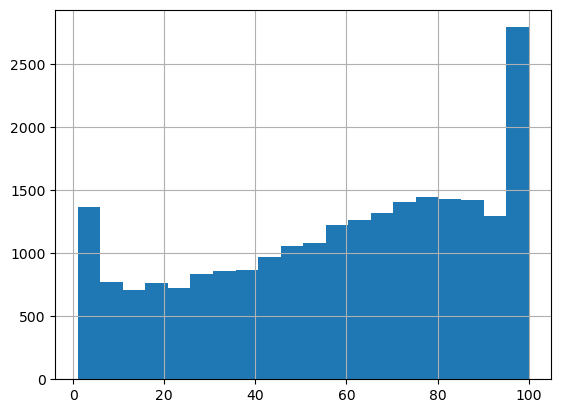

In [39]:
y_train.hist(bins=20);
#this is the distribution of the train split target data

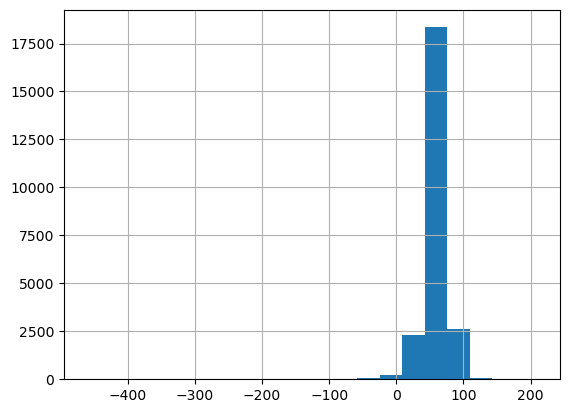

In [40]:
pd.Series(y_train_pred).hist(bins=20);
# the predicted target distribution doesn't look like the original at all
# also the score is ranging from -400 to +200, which is too broad

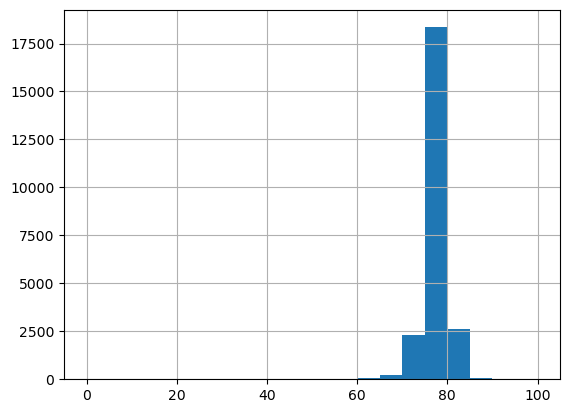

In [41]:
pd.Series(y_pred_norm).hist(bins=20);
# after normalizing the predictions between 0-100
# the distibrution has the exact same shape as the one above still
# it doesn't look like the original distribution at all

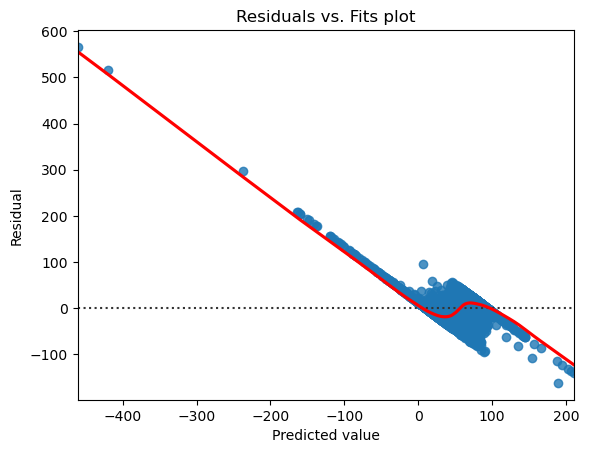

In [42]:
sns.residplot(x = y_train_pred, y = residuals, line_kws = {'color' : 'red'}, lowess = True)\
        .set(title = 'Residuals vs. Fits plot',
             xlabel = 'Predicted value',
             ylabel = 'Residual'); 
#residual vs fit plot

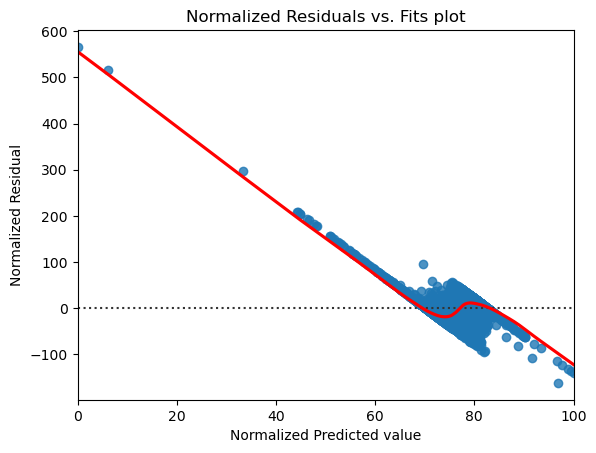

In [43]:
# 'residuals vs fit' plot
sns.residplot(x = y_pred_norm, y = residuals_norm, line_kws = {'color' : 'red'}, lowess = True)\
    .set(title = 'Normalized Residuals vs. Fits plot',
        xlabel = 'Normalized Predicted value',
        ylabel = 'Normalized Residual'); 
# normalized residual vs fit plot. shows the exact same shape and range of residuals, 
# but the predicted value falls between 0-100, which doesn't help much

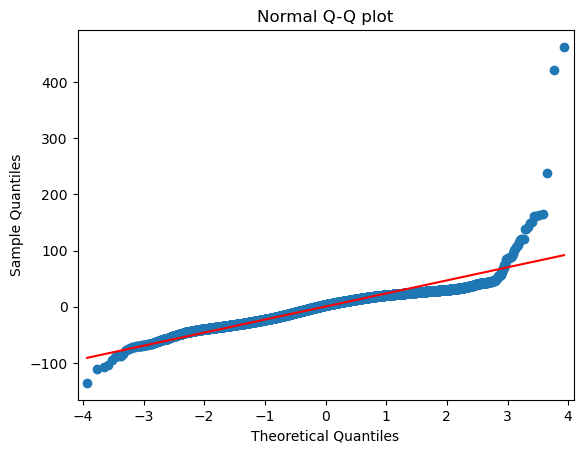

In [44]:
sm.qqplot(residuals,
         dist = stats.norm,
         line = 'q')

plt.title('Normal Q-Q plot');
# not a very normal Q-Q plot

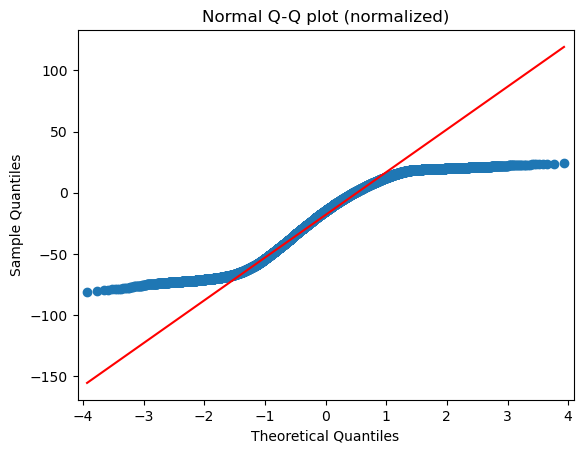

In [45]:
sm.qqplot(residuals_norm,
         dist = stats.norm,
         line = 'q')

plt.title('Normal Q-Q plot (normalized)');
# the normalized prediction also doesn't create a normal Q-Q plot